# Data Loading & Preprocessing

In [1]:
!pip install kagglehub

import kagglehub

path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease


In [2]:
# === 1A) Locate Correct Class Root Directory ===
import os
from pathlib import Path

root = Path("/kaggle/input/plantdisease")

def is_image_file(p):
    return p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def count_image_files_in_dir(d):
    count = 0
    for f in d.iterdir():
        if f.is_file() and is_image_file(f):
            count += 1
    return count

candidates = []
for dirpath, dirnames, filenames in os.walk(root):
    dirpath = Path(dirpath)
    subdirs = [dirpath / d for d in dirnames if not d.startswith(".")]
    if len(subdirs) >= 5:
        with_images = sum(1 for sd in subdirs if count_image_files_in_dir(sd) > 0)
        if with_images >= 5:
            candidates.append((dirpath, len(subdirs), with_images))

if not candidates:
    raise RuntimeError("Could not auto-detect class root. Please inspect the dataset tree manually.")
candidates.sort(key=lambda x: (x[2], x[1]), reverse=True)
class_root = candidates[0][0]
print("Detected class root:", class_root)

sample_classes = sorted([d.name for d in class_root.iterdir() if d.is_dir()])[:10]
print("Sample class folders:", sample_classes)

data_dir = str(class_root)



Detected class root: /kaggle/input/plantdisease/PlantVillage
Sample class folders: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']


In [3]:
# === 1B) Data Loading & Preprocessing (Re-run with Correct Path) ===
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT
)

train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_gen.num_classes
print("Number of classes:", num_classes)
print("Sample classes:", list(train_gen.class_indices.keys())[:10])


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Number of classes: 15
Sample classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']


## Dataset Visualization

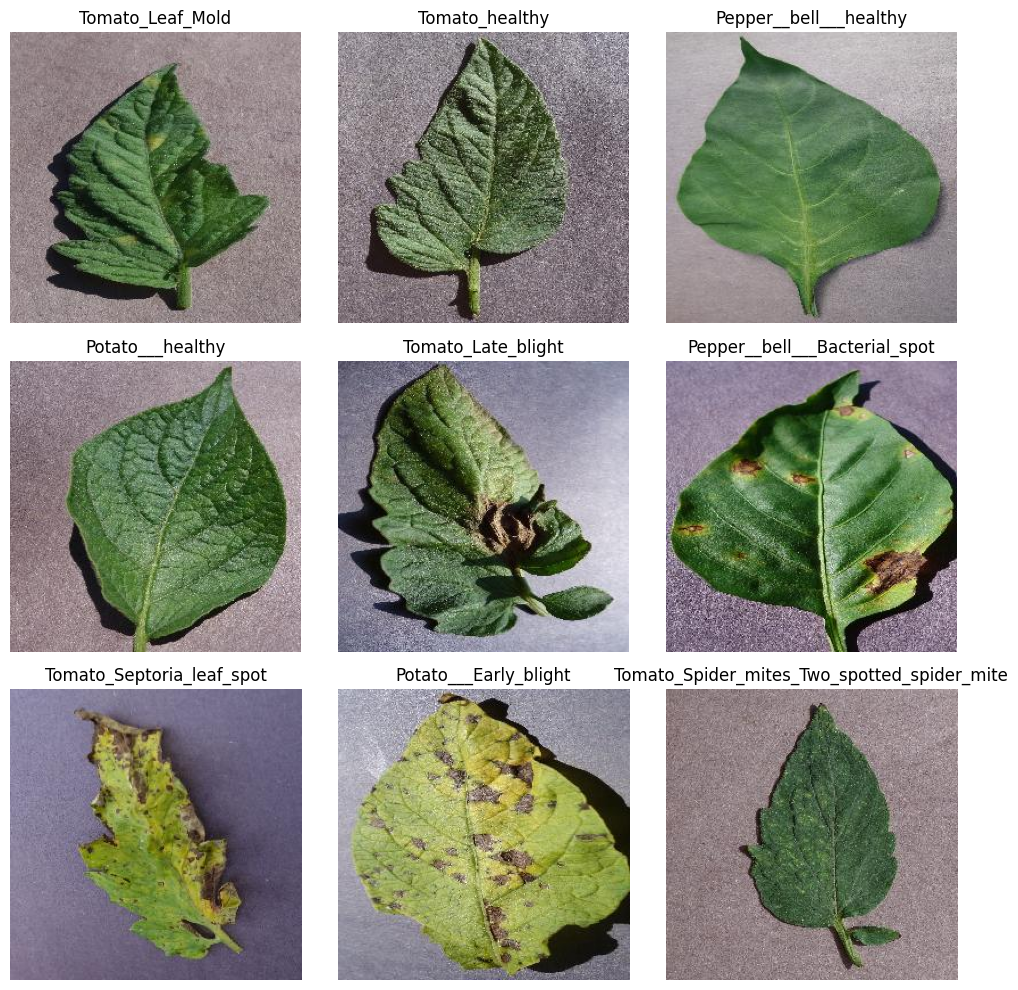

In [13]:
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing import image

sample_dir = train_gen.directory
classes = random.sample(list(train_gen.class_indices.keys()), 9)  # ✅ list() eklendi

plt.figure(figsize=(10, 10))
for i, cls in enumerate(classes):
    img_name = random.choice(os.listdir(os.path.join(sample_dir, cls)))
    img_path = os.path.join(sample_dir, cls, img_name)
    img = image.load_img(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Model: MobileNetV2 (Transfer Learning)

In [4]:
# === 2) Model: MobileNetV2 Transfer Learning ===
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

BASE_LR = 1e-3

base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3))
)
base_model.trainable = False  # freeze base for the initial phase

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # regularization
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=BASE_LR),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


/tmp/ipython-input-4039535477.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Architecture Visualization

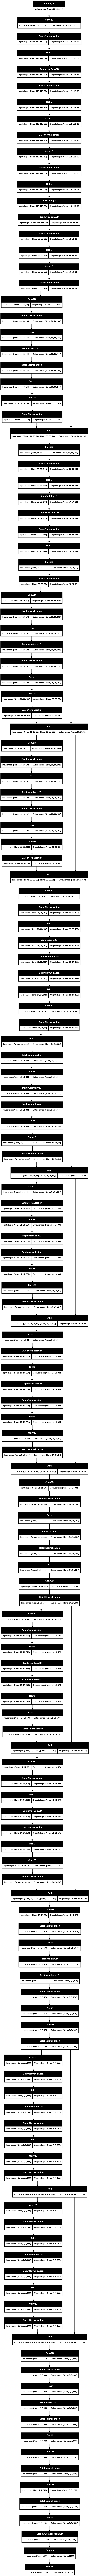

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='mobilenetv2_structure.png', show_shapes=True)


# Training (Frozen Base)

In [5]:
# === 3) Training (Frozen Base) ===
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

EPOCHS_FROZEN = 8
ckpt_path = "mobilenetv2_frozen_best.h5"

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

history_frozen = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FROZEN,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5733 - loss: 1.3916
Epoch 1: val_accuracy improved from -inf to 0.82751, saving model to mobilenetv2_frozen_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 336s 613ms/step - accuracy: 0.5736 - loss: 1.3907 - val_accuracy: 0.8275 - val_loss: 0.5185 - learning_rate: 0.0010
Epoch 2/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8353 - loss: 0.5104
Epoch 2: val_accuracy improved from 0.82751 to 0.86608, saving model to mobilenetv2_frozen_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 216s 418ms/step - accuracy: 0.8354 - loss: 0.5104 - val_accuracy: 0.8661 - val_loss: 0.3991 - learning_rate: 0.0010
Epoch 3/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8572 - loss: 0.4282
Epoch 3: val_accuracy improved from 0.86608 to 0.88840, saving model to mobilenetv2_frozen_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 211s 407ms/step - accuracy: 0.8572 - loss: 0.4282 - val_accuracy: 0.8884 - val_loss: 0.3463 - learning_rate: 0.0010
Epoch 4/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8775 - loss: 0.3746
Epoch 4: val_accuracy did not improve from 0.88840
517/517 ━━━━━━━━━━━━━━━━━━━━ 211s 409ms/step - accuracy: 0.8775 - loss: 0.3746 - val_accuracy: 0.8705 - val_loss: 0.3725 - learning_rate: 0.0010
Epoch 5/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8717 - loss: 0.3802
Epoch 5: val_accuracy improved from 0.88840 to 0.88937, saving model to mobilenetv2_frozen_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 219s 424ms/step - accuracy: 0.8717 - loss: 0.3801 - val_accuracy: 0.8894 - val_loss: 0.3228 - learning_rate: 0.0010
Epoch 6/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8828 - loss: 0.3516
Epoch 6: val_accuracy did not improve from 0.88937
517/517 ━━━━━━━━━━━━━━━━━━━━ 216s 417ms/step - accuracy: 0.8828 - loss: 0.3516 - val_accuracy: 0.8765 - val_loss: 0.3637 - learning_rate: 0.0010
Epoch 7/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8855 - loss: 0.3347
Epoch 7: val_accuracy did not improve from 0.88937

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
517/517 ━━━━━━━━━━━━━━━━━━━━ 216s 417ms/step - accuracy: 0.8855 - loss: 0.3347 - val_accuracy: 0.8688 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 8/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8928 - loss: 0.3176
Epoch 8: val_accuracy improved from 0.88937 to 0.89568, saving model to mobilenetv2_frozen_best.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 213s 412ms/step - accuracy: 0.8928 - loss: 0.3176 - val_accuracy: 0.8957 - val_loss: 0.3049 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 8.


# Fine-Tuning (Unfreeze Top Layers)

## Unfreeze Top Layers & Re-Compile

In [7]:
# === 4) Fine-Tuning (Unfreeze Top Layers) — robust without base_model var ===
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# 1) Find the GAP layer index (everything before it is backbone)
gap_idx = None
for i, layer in enumerate(model.layers):
    if isinstance(layer, GlobalAveragePooling2D):
        gap_idx = i
        break
if gap_idx is None:
    raise RuntimeError("Could not locate GlobalAveragePooling2D layer to split backbone/head.")

backbone_layers = model.layers[:gap_idx]   # MobileNetV2 body (approx.)
head_layers     = model.layers[gap_idx:]   # GAP + Dropout + Dense

# 2) Decide how much of the backbone to unfreeze (top 30%)
UNFREEZE_RATIO = 0.30
start_unfreeze = int(len(backbone_layers) * (1 - UNFREEZE_RATIO))

for i, layer in enumerate(backbone_layers):
    # Unfreeze only the top portion and skip BatchNorm for stability
    if i >= start_unfreeze and not isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

# Keep the head trainable
for layer in head_layers:
    layer.trainable = True

# 3) Re-compile with a lower LR for fine-tuning
FINE_TUNE_LR = 1e-4
model.compile(optimizer=Adam(learning_rate=FINE_TUNE_LR),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# 4) Fit
EPOCHS_FINE = 10
ckpt_path_ft = "mobilenetv2_finetune_best.keras"

callbacks_ft = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(ckpt_path_ft, monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    callbacks=callbacks_ft
)


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8375 - loss: 0.5115
Epoch 1: val_accuracy improved from -inf to 0.91703, saving model to mobilenetv2_finetune_best.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 244s 443ms/step - accuracy: 0.8375 - loss: 0.5113 - val_accuracy: 0.9170 - val_loss: 0.2382 - learning_rate: 1.0000e-04
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9249 - loss: 0.2223
Epoch 2: val_accuracy improved from 0.91703 to 0.95099, saving model to mobilenetv2_finetune_best.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 214s 414ms/step - accuracy: 0.9249 - loss: 0.2222 - val_accuracy: 0.9510 - val_loss: 0.1519 - learning_rate: 1.0000e-04
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9480 - loss: 0.1474
Epoch 3: val_accuracy did not improve from 0.95099
517/517 ━━━━━━━━━━━━━━━━━━━━ 214s 414ms/step - accuracy: 0.9480 - loss: 0.1474 - val_accuracy: 0.9508 - val_loss: 0.1428 - learning_rate: 1.0000e-04
Epoch 4/10
517/517 ━━━━━━━━━━━━━━

## Learning Curves

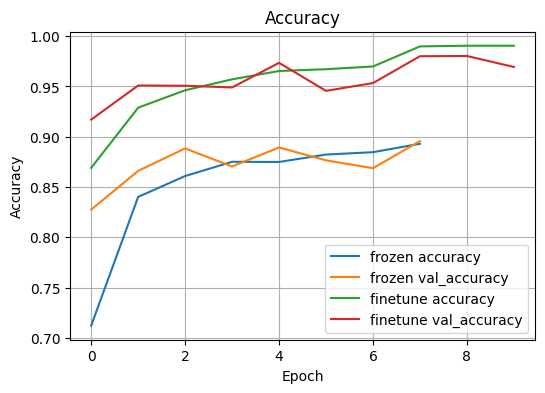

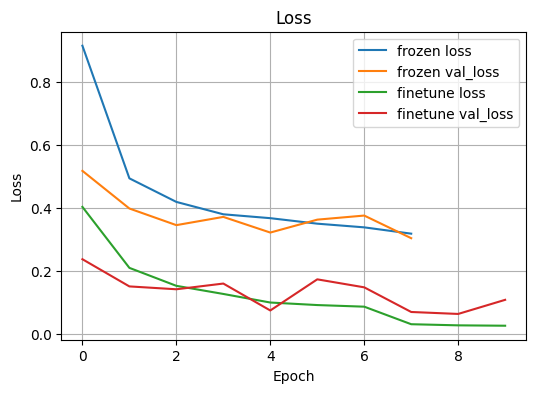

In [8]:
# === 5) Learning Curves (Accuracy & Loss) ===
import matplotlib.pyplot as plt

def plot_metric(histories, metric):
    plt.figure(figsize=(6,4))
    for h, label in histories:
        plt.plot(h.history[metric], label=f'{label} {metric}')
        plt.plot(h.history[f'val_{metric}'], label=f'{label} val_{metric}')
    plt.title(metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric([(history_frozen, "frozen"), (history_ft, "finetune")], "accuracy")
plot_metric([(history_frozen, "frozen"), (history_ft, "finetune")], "loss")


## Evaluation Metrics

129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.9900    1.0000    0.9950       199
                     Pepper__bell___healthy     1.0000    0.9966    0.9983       295
                      Potato___Early_blight     0.9901    1.0000    0.9950       200
                       Potato___Late_blight     1.0000    0.9900    0.9950       200
                           Potato___healthy     0.9667    0.9667    0.9667        30
                      Tomato_Bacterial_spot     0.9975    0.9506    0.9735       425
                        Tomato_Early_blight     0.9624    0.8950    0.9275       200
                         Tomato_Late_blight     0.9818    0.9895    0.9856       381
                           Tomato_Leaf_Mold     1.0000    0.9737    0.9867       190
                  Tomato_Septoria_leaf_spot     0.9452    0.9746    0.9597       354
Tomato_Spider_mites_Tw

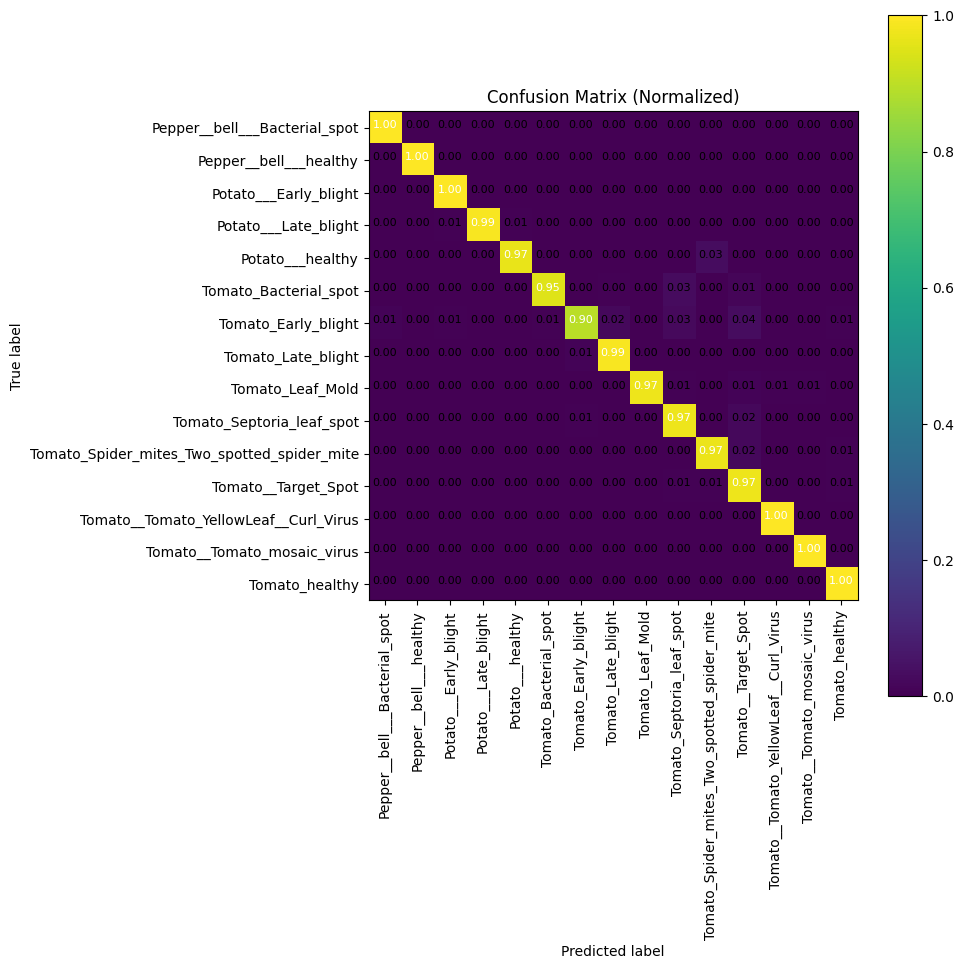

In [15]:
# === 6) Evaluation: Classification Report & Confusion Matrix ===
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np, itertools
import matplotlib.pyplot as plt

val_gen.reset()
pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes
target_names = list(train_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# Macro metrics
macro_p = precision_score(y_true, y_pred, average='macro')
macro_r = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro Precision: {macro_p:.4f}  Macro Recall: {macro_r:.4f}  Macro F1: {macro_f1:.4f}")

cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=True):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=8)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, target_names, normalize=True)


## Model Saving

In [10]:
# === 7) Save Artifacts (Model & Labels) ===
import json

MODEL_PATH = "mobilenetv2_plantvillage_15cls.keras"  # modern format
LABELS_PATH = "class_indices_15cls.json"

model.save(MODEL_PATH)
with open(LABELS_PATH, "w") as f:
    json.dump({v:k for k,v in train_gen.class_indices.items()}, f, indent=2)

print("Saved:", MODEL_PATH, "and", LABELS_PATH)


Saved: mobilenetv2_plantvillage_15cls.keras and class_indices_15cls.json


## Inference Demo

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


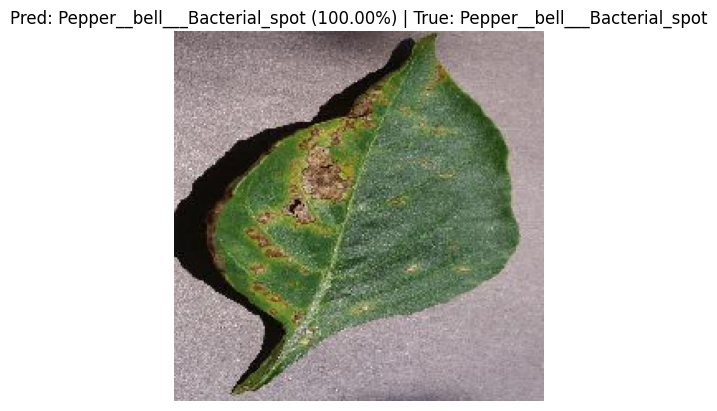

In [11]:
# === 8) Inference Demo (Single Image) ===
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

imgs, labels = next(iter(val_gen))
img = imgs[0]
true_idx = int(np.argmax(labels[0]))

pred = model.predict(np.expand_dims(img, axis=0))
pred_idx = int(np.argmax(pred[0]))
pred_label = target_names[pred_idx]
conf = float(np.max(pred[0]))

viz = (img * 127.5 + 127.5).astype("uint8")  # undo [-1,1] scaling for display
plt.imshow(viz); plt.axis("off")
plt.title(f"Pred: {pred_label} ({conf:.2%}) | True: {target_names[true_idx]}")
plt.show()
